In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from conda.instructions import PRINT

# NSS parameters from St-Louis Fed
beta0 = 3.385571197
beta1 = 0.938107702
beta2 = -7.40E-05
beta3 = 4.296030822
tau1 = 1.227066261
tau2 = 18.49221165

# Define NSS curve function
def nss_curve(t, beta0, beta1, beta2, beta3, tau1, tau2):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t / tau1)) / (t / tau1))
    term3 = beta2 * (((1 - np.exp(-t / tau1)) / (t / tau1)) - np.exp(-t / tau1))
    term4 = beta3 * (((1 - np.exp(-t / tau2)) / (t / tau2)) - np.exp(-t / tau2))
    return term1 + term2 + term3 + term4

# Observed AA yields
maturities = np.array([0.5, 1, 2, 3, 4, 5, 7, 10, 12, 15, 20, 30])
aa_yields = np.array([4.50, 4.53, 4.59, 4.66, 4.73, 4.81, 5.01, 5.28, 5.42, 5.55, 5.67, 5.77])

# Get treasury yields
risk_free_yields = nss_curve(maturities, beta0, beta1, beta2, beta3, tau1, tau2)

# Get credit spread
credit_spreads = aa_yields - risk_free_yields

# Store results
df_results = pd.DataFrame({
    'Maturity (Years)': maturities,
    'Risk-Free Yield (%)': risk_free_yields.round(2),
    'AA Yield (%)': aa_yields,
    'Credit Spread (bps)': credit_spreads.round(4) * 100  # Convert to basis points
})

df_results

,Maturity (Years),Risk-Free Yield (%),AA Yield (%),Credit Spread (bps)
0,0.5,4.21,4.50,28.69
1,1.0,4.14,4.53,39.08
2,2.0,4.06,4.59,52.54
3,3.0,4.05,4.66,61.10
4,4.0,4.07,4.73,66.50
5,5.0,4.10,4.81,71.21
6,7.0,4.18,5.01,82.62
7,10.0,4.32,5.28,96.26
8,12.0,4.40,5.42,102.32
9,15.0,4.50,5.55,105.38


In [23]:
################################
##### One Step Calibration #####
################################
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


def cir_zero_coupon_price(r0, kappa, theta, sigma, T):
    """
    Closed-form solution for CIR zero-coupon bond price.
    """
    gamma = np.sqrt(kappa**2 + 2 * sigma**2)
    numerator = 2 * gamma * np.exp((kappa + gamma) * T / 2)
    denominator = (gamma + kappa) * (np.exp(gamma * T) - 1) + 2 * gamma
    A = (numerator / denominator) ** (2 * kappa * theta / sigma**2)
    B = (2 * (np.exp(gamma * T) - 1)) / denominator
    return A * np.exp(-B * r0)


class DuffeeModel:
    def __init__(self, df_results):
        # Store observed market data
        self.df_results = df_results
        self.maturities = df_results['Maturity (Years)'].values
        self.rf_yields = df_results['Risk-Free Yield (%)'].values / 100  # Convert to decimal
        self.aa_yields = df_results['AA Yield (%)'].values / 100  # Convert to decimal

        # Initial parameter guesses
        self.r0 = np.mean(self.rf_yields)
        self.kappa_r = 0.1
        self.theta_r = self.r0
        self.sigma_r = 0.1

        self.s0 = 0.01
        self.kappa_s = 0.1
        self.theta_s = 0.02
        self.sigma_s = 0.1
        self.alpha = 0.01
        self.beta = 0.5

    def calibrate(self):
        def objective(params):
            r0, kappa_r, theta_r, sigma_r, s0, kappa_s, theta_s, sigma_s, alpha, beta = params

            rf_yields = [r0 + (theta_r - r0) * (1 - np.exp(-kappa_r * t)) for t in self.maturities]
            credit_spreads = [s0 + (theta_s - s0) * (1 - np.exp(-kappa_s * t)) for t in self.maturities]
            bond_prices = [cir_zero_coupon_price(r0, kappa_r, theta_r, sigma_r, t) for t in self.maturities]

            theoretical_aa_yields = [
                (-1 / t) * np.log(P) + alpha + beta * rf + spread
                for t, P, rf, spread in zip(self.maturities, bond_prices, rf_yields, credit_spreads)
            ]

            return np.sum((np.array(theoretical_aa_yields) - self.aa_yields) ** 2)

        initial_guess = [
            self.r0, self.kappa_r, self.theta_r, self.sigma_r,
            self.s0, self.kappa_s, self.theta_s, self.sigma_s,
            self.alpha, self.beta
        ]

        bounds = [
            (0.0, 0.1),    # r0
            (0.0001, 1.0),  # kappa_r
            (0.0, 0.1),     # theta_r
            (0.0001, 0.5),  # sigma_r
            (0.0, 0.05),    # s0
            (0.0001, 1.0),  # kappa_s
            (0.0, 0.05),    # theta_s
            (0.0001, 0.5),  # sigma_s
            (0.0, 0.05),    # alpha
            (-1.0, 1.0)     # beta
        ]

        result = optimize.minimize(objective, initial_guess, method='trust-constr', bounds=bounds)

        self.r0, self.kappa_r, self.theta_r, self.sigma_r, \
        self.s0, self.kappa_s, self.theta_s, self.sigma_s, \
        self.alpha, self.beta = result.x

        print("Calibrated Parameters:")
        print(f"r0: {self.r0:.4f}")
        print(f"kappa_r: {self.kappa_r:.4f}")
        print(f"theta_r: {self.theta_r:.4f}")
        print(f"sigma_r: {self.sigma_r:.4f}")
        print(f"s0: {self.s0:.4f}")
        print(f"kappa_s: {self.kappa_s:.4f}")
        print(f"theta_s: {self.theta_s:.4f}")
        print(f"sigma_s: {self.sigma_s:.4f}")
        print(f"alpha: {self.alpha:.4f}")
        print(f"beta: {self.beta:.4f}")

    def plot_calibration(self):
        plt.figure(figsize=(12, 7))
        plt.scatter(self.maturities, self.aa_yields, label='Observed AA Yields', color='black')

        rf_yields = [self.r0 + (self.theta_r - self.r0) * (1 - np.exp(-self.kappa_r * t)) for t in self.maturities]
        spreads = [self.s0 + (self.theta_s - self.s0) * (1 - np.exp(-self.kappa_s * t)) for t in self.maturities]
        bond_prices = [cir_zero_coupon_price(self.r0, self.kappa_r, self.theta_r, self.sigma_r, t) for t in self.maturities]

        aa_yields_theoretical = [
            (-1 / t) * np.log(P) + self.alpha + self.beta * rf + spread
            for t, P, rf, spread in zip(self.maturities, bond_prices, rf_yields, spreads)
        ]

        aa_yields_theoretical = gaussian_filter1d(aa_yields_theoretical, sigma=0.5)

        plt.plot(self.maturities, aa_yields_theoretical, label='Theoretical AA Yields', color='gray', linestyle='--')
        plt.title('Duffee (1999) Model: Yields Comparison')
        plt.xlabel('Maturity (Years)')
        plt.ylabel('Yield')
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_spread_comparison(self):
        """
        Plot theoretical vs observed credit spreads.
        """
        rf_yields = [self.r0 + (self.theta_r - self.r0) * (1 - np.exp(-self.kappa_r * t)) for t in self.maturities]
        spreads_theoretical = [
            (self.alpha + self.beta * rf + self.s0 + (self.theta_s - self.s0) * (1 - np.exp(-self.kappa_s * t)))
            for rf, t in zip(rf_yields, self.maturities)
        ]
        observed_spreads = self.df_results['Credit Spread (bps)'].values

        plt.figure(figsize=(10, 6))
        plt.plot(self.maturities, np.array(spreads_theoretical) * 10000, label='Theoretical Spread (bps)', linestyle='--')
        plt.plot(self.maturities, observed_spreads, label='Observed Spread (bps)', marker='o')
        plt.xlabel("Maturity (Years)")
        plt.ylabel("Credit Spread (bps)")
        plt.title("Credit Spread: Model vs Market")
        plt.grid(True)
        plt.legend()
        plt.show()

Calibrated Parameters:
r0: 0.0089
kappa_r: 0.1592
theta_r: 0.0398
sigma_r: 0.2775
s0: 0.0241
kappa_s: 0.3372
theta_s: 0.0060
sigma_s: 0.1907
alpha: 0.0068
beta: 0.6147


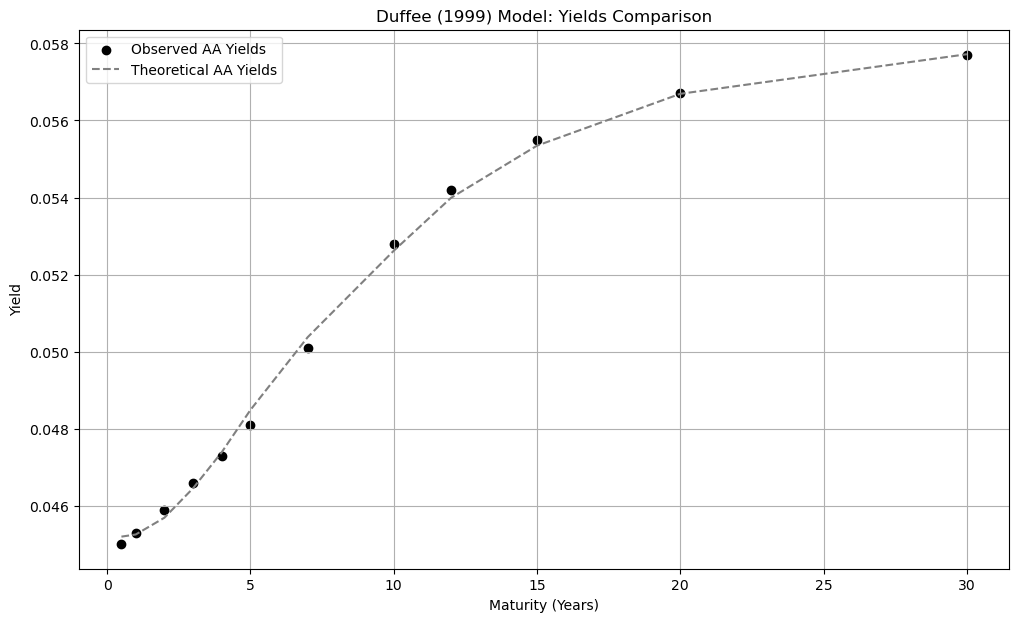

In [25]:
model = DuffeeModel(df_results)
model.calibrate()
model.plot_calibration()

Step 1 parameters: r0=0.0405, kappa_r=0.0080, theta_r=0.1000, sigma_r=0.0004
Optimization error: 0.00002449
Step 2 parameters: s0=0.000169, kappa_s=0.1637, theta_s=0.011198, sigma_s=0.0165, alpha=-0.008160, beta=0.2815
Optimization error: 0.00000988

===== Duffee Model Calibration Summary =====
Risk-Free Yield Curve Parameters (Step 1):
  r0 (initial short rate): 0.040535
  kappa_r (mean-reversion speed): 0.007956
  theta_r (long-term mean): 0.100000
  sigma_r (volatility): 0.000368

Defaultable Yield Curve Parameters (Step 2):
  s0 (initial credit spread): 0.000169
  kappa_s (credit spread mean-reversion speed): 0.163740
  theta_s (credit spread long-term mean): 0.011198
  sigma_s (credit spread volatility): 0.016501
  alpha (constant risk premium): -0.008160
  beta (risk sensitivity coefficient): 0.281498

Fit Quality Metrics:
  Risk-Free Yield RMSE: 0.000782
  AA Yield RMSE: 0.000809


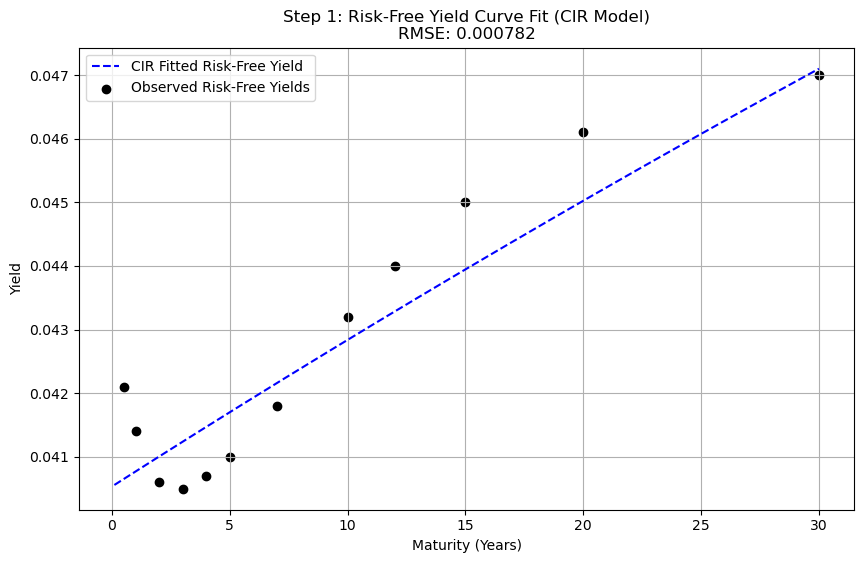

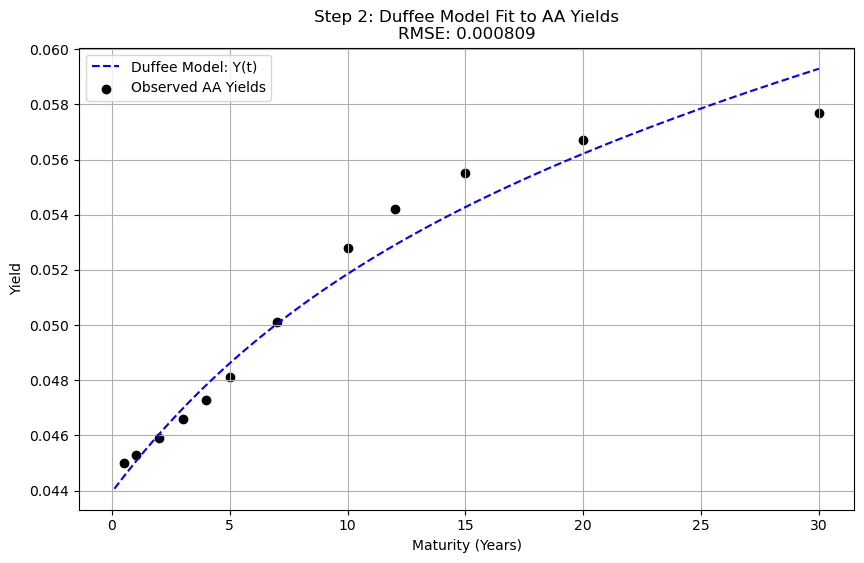

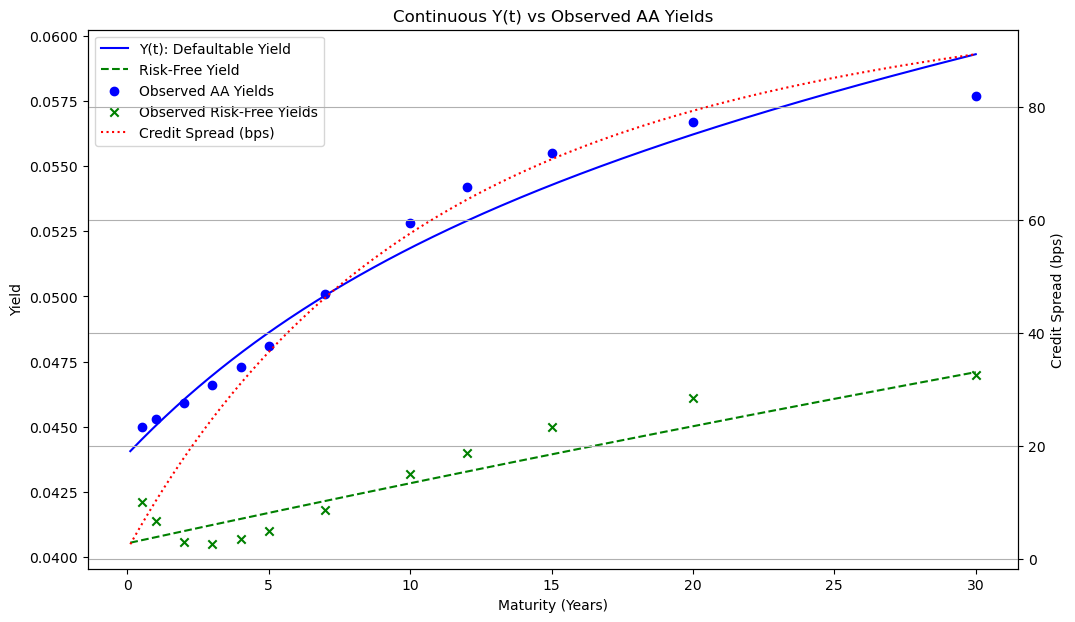

In [27]:
################################
##### Two Step Calibration #####
################################
import numpy as np
import pandas as pd
import scipy.optimize as optimize
import matplotlib.pyplot as plt

def cir_zero_coupon_bond_price(r, kappa, theta, sigma, T):
    """
    Calculate zero-coupon bond price under CIR model
    r: current short rate
    kappa: mean-reversion speed
    theta: long-term mean level
    sigma: volatility
    T: maturity
    """
    gamma = np.sqrt(kappa**2 + 2 * sigma**2)
    denominator = 2 * gamma + (kappa + gamma) * (np.exp(gamma * T) - 1)
    A = ((2 * gamma * np.exp((kappa + gamma) * T / 2)) / denominator) ** (2 * kappa * theta / sigma**2)
    B = 2 * (np.exp(gamma * T) - 1) / denominator
    
    price = A * np.exp(-B * r)
    return price

def cir_zero_coupon_yield(r, kappa, theta, sigma, T):
    """
    Calculate zero-coupon yield under CIR model
    """
    price = cir_zero_coupon_bond_price(r, kappa, theta, sigma, T)
    yield_value = -np.log(price) / T
    return yield_value

class DuffeeModelTwoStep:
    def __init__(self, df_results):
        self.df_results = df_results
        self.maturities = df_results['Maturity (Years)'].values
        self.rf_yields = df_results['Risk-Free Yield (%)'].values / 100  # Risk-free yields
        self.aa_yields = df_results['AA Yield (%)'].values / 100  # AA-rated bond yields
        self.credit_spreads = df_results['Credit Spread (bps)'].values / 10000  # Credit spreads (convert to decimal)
        
    def fit_step1_risk_free(self):
        """
        Step 1: Fit the risk-free zero-coupon yield curve
        Obtain parameters r0, kappa_r, theta_r, sigma_r
        Use weighted optimization to improve short-term fit
        """
        def objective_rf(params):
            r0, kappa_r, theta_r, sigma_r = params
            
            # Calculate theoretical risk-free yields using CIR model
            rf_theo = [cir_zero_coupon_yield(r0, kappa_r, theta_r, sigma_r, t) for t in self.maturities]
            
            # Assign higher weights to short-term yields
            weights = [5.0 if t <= 5.0 else 1.0 for t in self.maturities]
            
            # Calculate weighted squared errors
            weighted_errors = [(theo - obs)**2 * w for theo, obs, w in zip(rf_theo, self.rf_yields, weights)]
            
            return np.sum(weighted_errors)
        
        # Try multiple initial parameter sets to avoid local minima
        initial_sets = [
            [0.04, 0.01, 0.05, 0.01],   # Low kappa may help capture short-term features
            [0.04, 0.005, 0.045, 0.02],
            [0.035, 0.02, 0.05, 0.008],
            [0.042, 0.015, 0.042, 0.012],
            [0.038, 0.008, 0.048, 0.015],
            [0.041, 0.03, 0.041, 0.005],
            [0.04, 0.002, 0.06, 0.02],
            [0.045, 0.001, 0.055, 0.01],
            [0.037, 0.004, 0.047, 0.018]
        ]
        
        best_result = None
        min_error = float('inf')
        
        # Wider bounds for parameters, especially kappa
        bounds = [(0.001, 0.1), (0.0001, 5.0), (0.001, 0.1), (0.0001, 0.5)]
        
        for initial in initial_sets:
            result = optimize.minimize(objective_rf, initial, method='L-BFGS-B', bounds=bounds)
            
            if result.fun < min_error:
                min_error = result.fun
                best_result = result
        
        self.r0, self.kappa_r, self.theta_r, self.sigma_r = best_result.x
        print(f"Step 1 parameters: r0={self.r0:.4f}, kappa_r={self.kappa_r:.4f}, theta_r={self.theta_r:.4f}, sigma_r={self.sigma_r:.4f}")
        print(f"Optimization error: {min_error:.8f}")
        
    def fit_step2_defaultable(self):
        """
        Step 2: Fit the defaultable (AA-rated) zero-coupon yield curve
        Obtain parameters s0, kappa_s, theta_s, sigma_s, alpha, beta
        Given the risk-free parameters from Step 1
        """
        def objective_credit(params):
            s0, kappa_s, theta_s, sigma_s, alpha, beta = params
            
            # Calculate theoretical risk-free yields using parameters from Step 1
            rf_theo = [cir_zero_coupon_yield(self.r0, self.kappa_r, self.theta_r, self.sigma_r, t) for t in self.maturities]
            
            # Calculate credit spreads using CIR model
            spreads = [cir_zero_coupon_yield(s0, kappa_s, theta_s, sigma_s, t) for t in self.maturities]
            
            # Calculate risk premium component
            risk_premium = [alpha + beta * self.r0 for _ in self.maturities]
            
            # Calculate theoretical AA yields
            aa_theo = [rf + spread + premium for rf, spread, premium in zip(rf_theo, spreads, risk_premium)]
            
            # Assign higher weights to short-term yields
            weights = [3.0 if t <= 5.0 else 1.0 for t in self.maturities]
            
            # Calculate weighted squared errors
            weighted_errors = [(theo - obs)**2 * w for theo, obs, w in zip(aa_theo, self.aa_yields, weights)]
            
            return np.sum(weighted_errors)
        
        # Try multiple initial parameter sets
        initial_sets = [
            [0.002, 0.1, 0.01, 0.01, 0.001, 0.1],
            [0.001, 0.2, 0.008, 0.02, 0.002, 0.2],
            [0.003, 0.15, 0.012, 0.015, 0.0, 0.15],
            [0.0005, 0.3, 0.01, 0.008, 0.001, 0.05],
            [0.002, 0.05, 0.015, 0.01, 0.0005, 0.08],
            [0.001, 0.4, 0.005, 0.03, 0.002, 0.12],
            [0.0008, 0.25, 0.01, 0.025, 0.001, 0.3]
        ]
        
        best_result = None
        min_error = float('inf')
        
        # Wider bounds for parameters
        bounds = [(0.00001, 0.05), (0.0001, 3.0), (0.0001, 0.05), (0.0001, 0.5), (-0.02, 0.02), (-1.0, 1.0)]
        
        for initial in initial_sets:
            result = optimize.minimize(objective_credit, initial, method='L-BFGS-B', bounds=bounds)
            
            if result.fun < min_error:
                min_error = result.fun
                best_result = result
        
        self.s0, self.kappa_s, self.theta_s, self.sigma_s, self.alpha, self.beta = best_result.x
        print(f"Step 2 parameters: s0={self.s0:.6f}, kappa_s={self.kappa_s:.4f}, theta_s={self.theta_s:.6f}, sigma_s={self.sigma_s:.4f}, alpha={self.alpha:.6f}, beta={self.beta:.4f}")
        print(f"Optimization error: {min_error:.8f}")
        
    def plot_risk_free_fit(self):
        """Plot risk-free yield curve fit results"""
        t_range = np.linspace(0.1, 30, 300)
        rf_fitted = [cir_zero_coupon_yield(self.r0, self.kappa_r, self.theta_r, self.sigma_r, t) for t in t_range]
        
        # Calculate RMSE
        rf_theo = [cir_zero_coupon_yield(self.r0, self.kappa_r, self.theta_r, self.sigma_r, t) for t in self.maturities]
        rmse = np.sqrt(np.mean((np.array(rf_theo) - self.rf_yields) ** 2))
        
        plt.figure(figsize=(10, 6))
        plt.plot(t_range, rf_fitted, label='CIR Fitted Risk-Free Yield', linestyle='--', color='blue')
        plt.scatter(self.maturities, self.rf_yields, color='black', label='Observed Risk-Free Yields')
        plt.xlabel('Maturity (Years)')
        plt.ylabel('Yield')
        plt.title(f'Step 1: Risk-Free Yield Curve Fit (CIR Model)\nRMSE: {rmse:.6f}')
        plt.grid(True)
        plt.legend()
        plt.show()
        
    def plot_defaultable_fit(self):
        """Plot AA-rated bond yield curve fit results"""
        t_range = np.linspace(0.1, 30, 300)
        
        # Calculate theoretical risk-free yields
        rf_theo = [cir_zero_coupon_yield(self.r0, self.kappa_r, self.theta_r, self.sigma_r, t) for t in t_range]
        
        # Calculate credit spreads
        spreads = [cir_zero_coupon_yield(self.s0, self.kappa_s, self.theta_s, self.sigma_s, t) for t in t_range]
        
        # Calculate risk premium
        risk_premium = [self.alpha + self.beta * self.r0 for _ in t_range]
        
        # Calculate AA yields
        aa_fitted = [rf + spread + premium for rf, spread, premium in zip(rf_theo, spreads, risk_premium)]
        
        # Calculate RMSE
        aa_theo = []
        for t in self.maturities:
            rf = cir_zero_coupon_yield(self.r0, self.kappa_r, self.theta_r, self.sigma_r, t)
            spread = cir_zero_coupon_yield(self.s0, self.kappa_s, self.theta_s, self.sigma_s, t)
            premium = self.alpha + self.beta * self.r0
            aa_theo.append(rf + spread + premium)
            
        rmse = np.sqrt(np.mean((np.array(aa_theo) - self.aa_yields) ** 2))
        
        plt.figure(figsize=(10, 6))
        plt.plot(t_range, aa_fitted, label='Duffee Model: Y(t)', linestyle='--', color='blue')
        plt.scatter(self.maturities, self.aa_yields, color='black', label='Observed AA Yields')
        plt.xlabel('Maturity (Years)')
        plt.ylabel('Yield')
        plt.title(f'Step 2: Duffee Model Fit to AA Yields\nRMSE: {rmse:.6f}')
        plt.grid(True)
        plt.legend()
        plt.show()
        
    def plot_combined_yield_curves(self):
        """Plot combined yield curves and credit spread"""
        t_range = np.linspace(0.1, 30, 300)
        
        # Calculate theoretical risk-free yields
        rf_theo = [cir_zero_coupon_yield(self.r0, self.kappa_r, self.theta_r, self.sigma_r, t) for t in t_range]
        
        # Calculate credit spreads
        spreads = [cir_zero_coupon_yield(self.s0, self.kappa_s, self.theta_s, self.sigma_s, t) for t in t_range]
        credit_spreads_bps = [spread * 10000 for spread in spreads]  # Convert to basis points
        
        # Calculate risk premium
        risk_premium = [self.alpha + self.beta * self.r0 for _ in t_range]
        
        # Calculate AA yields
        aa_fitted = [rf + spread + premium for rf, spread, premium in zip(rf_theo, spreads, risk_premium)]
        
        # Create figure with dual y-axes
        fig, ax1 = plt.subplots(figsize=(12, 7))
        
        # Left y-axis: Yields
        ax1.plot(t_range, aa_fitted, label='Y(t): Defaultable Yield', color='blue')
        ax1.plot(t_range, rf_theo, label='Risk-Free Yield', color='green', linestyle='--')
        ax1.scatter(self.maturities, self.aa_yields, label='Observed AA Yields', color='blue', marker='o')
        ax1.scatter(self.maturities, self.rf_yields, label='Observed Risk-Free Yields', color='green', marker='x')
        ax1.set_xlabel('Maturity (Years)')
        ax1.set_ylabel('Yield')
        ax1.tick_params(axis='y')
        
        # Right y-axis: Credit spread (basis points)
        ax2 = ax1.twinx()
        ax2.plot(t_range, credit_spreads_bps, label='Credit Spread (bps)', color='red', linestyle=':')
        ax2.set_ylabel('Credit Spread (bps)')
        ax2.tick_params(axis='y')
        
        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
        
        plt.title('Continuous Y(t) vs Observed AA Yields')
        plt.grid(True)
        plt.show()
        
    def print_optimization_summary(self):
        """Print optimization results summary"""
        print("\n===== Duffee Model Calibration Summary =====")
        print("Risk-Free Yield Curve Parameters (Step 1):")
        print(f"  r0 (initial short rate): {self.r0:.6f}")
        print(f"  kappa_r (mean-reversion speed): {self.kappa_r:.6f}")
        print(f"  theta_r (long-term mean): {self.theta_r:.6f}")
        print(f"  sigma_r (volatility): {self.sigma_r:.6f}")
        
        print("\nDefaultable Yield Curve Parameters (Step 2):")
        print(f"  s0 (initial credit spread): {self.s0:.6f}")
        print(f"  kappa_s (credit spread mean-reversion speed): {self.kappa_s:.6f}")
        print(f"  theta_s (credit spread long-term mean): {self.theta_s:.6f}")
        print(f"  sigma_s (credit spread volatility): {self.sigma_s:.6f}")
        print(f"  alpha (constant risk premium): {self.alpha:.6f}")
        print(f"  beta (risk sensitivity coefficient): {self.beta:.6f}")
        
        # Calculate fit quality metrics
        rf_theo = [cir_zero_coupon_yield(self.r0, self.kappa_r, self.theta_r, self.sigma_r, t) for t in self.maturities]
        rf_rmse = np.sqrt(np.mean((np.array(rf_theo) - self.rf_yields) ** 2))
        
        aa_theo = []
        for t in self.maturities:
            rf = cir_zero_coupon_yield(self.r0, self.kappa_r, self.theta_r, self.sigma_r, t)
            spread = cir_zero_coupon_yield(self.s0, self.kappa_s, self.theta_s, self.sigma_s, t)
            premium = self.alpha + self.beta * self.r0
            aa_theo.append(rf + spread + premium)
            
        aa_rmse = np.sqrt(np.mean((np.array(aa_theo) - self.aa_yields) ** 2))
        
        print("\nFit Quality Metrics:")
        print(f"  Risk-Free Yield RMSE: {rf_rmse:.6f}")
        print(f"  AA Yield RMSE: {aa_rmse:.6f}")
        print("========================================")

# Example usage
if __name__ == "__main__":
    # Create sample data frame or load from file
    data = {
        'Maturity (Years)': [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 10.0, 12.0, 15.0, 20.0, 30.0],
        'Risk-Free Yield (%)': [4.21, 4.14, 4.06, 4.05, 4.07, 4.10, 4.18, 4.32, 4.40, 4.50, 4.61, 4.70],
        'AA Yield (%)': [4.50, 4.53, 4.59, 4.66, 4.73, 4.81, 5.01, 5.28, 5.42, 5.55, 5.67, 5.77],
    }
    
    # Calculate credit spreads (bps)
    data['Credit Spread (bps)'] = [(aa - rf) * 100 for aa, rf in zip(data['AA Yield (%)'], data['Risk-Free Yield (%)'])]
    
    df_results = pd.DataFrame(data)
    
    # Create model and fit
    model = DuffeeModelTwoStep(df_results)
    model.fit_step1_risk_free()
    model.fit_step2_defaultable()
    
    # Print optimization summary
    model.print_optimization_summary()
    
    # Plot results
    model.plot_risk_free_fit()
    model.plot_defaultable_fit()
    model.plot_combined_yield_curves()